Plot snapshot of zonally averaged KE.

In [1]:
import numpy as np
import xarray as xr
import cmocean as cmocean
import numpy.linalg as la
from scipy.io import netcdf
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from xgcm import Grid
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from matplotlib.colors import SymLogNorm, BoundaryNorm, LogNorm
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import MaxNLocator


mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern Roman']

In [2]:
# Snapshot
root = '/scratch/mp6191/NW2_TracerBackscatter'

exp = '/p5_noBS_KHTR0_2'
p5_noBS = xr.open_mfdataset(root + exp + '/snapshots*.nc', decode_times = False)#.isel(time = -1)
p5_static = xr.open_dataset(root + exp + '/static.nc', decode_times = False)
p5_eta = xr.open_dataset(root + exp + '/MOM_IC.nc', decode_times = False).eta.isel(Time = -1)

exp = '/p5_SQGBS_KHTR0_2'
p5_SQGBS = xr.open_mfdataset(root + exp + '/snapshots*.nc', decode_times = False)#.isel(time = -1)

exp = '/p25_noBS_2'
p25_noBS = xr.open_mfdataset(root + exp + '/snapshots*.nc', decode_times = False)#.isel(time = -1)
p25_static = xr.open_dataset(root + exp + '/static.nc', decode_times = False)
p25_eta = xr.open_dataset(root + '/p25_SpinUp' + '/MOM_IC.nc', decode_times = False).eta.isel(Time = -1)

exp = '/p25_SQGBS_2'
p25_SQGBS = xr.open_mfdataset(root + exp + '/snapshots*.nc', decode_times = False)#.isel(time = -1)

exp = '/p03125_2'
p03125 = xr.open_mfdataset(root + exp + '/snapshots*.nc', decode_times = False).isel(time = slice(None, 180, 2))#.isel(time = -1)
p03125_static = xr.open_dataset(root + exp + '/static.nc', decode_times = False)
p03125_eta = xr.open_dataset('/scratch/mp6191/NW2_TracerBackscatter/p03125_IC/MOM_IC_4.nc', decode_times = False).eta.isel(Time = -1)

# Grid
p5_grid = Grid(p5_noBS, coords = {'X': {'center': 'xh', 'outer': 'xq'},
                                  'Y': {'center': 'yh', 'outer': 'yq'}})

p25_grid = Grid(p25_noBS, coords = {'X': {'center': 'xh', 'outer': 'xq'},
                                    'Y': {'center': 'yh', 'outer': 'yq'}})

p03125_grid = Grid(p03125, coords = {'X': {'center': 'xh', 'outer': 'xq'},
                                     'Y': {'center': 'yh', 'outer': 'yq'}})

/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Ser

In [15]:
def calc_KE(ds, grid):

    u = grid.interp(ds.u, axis = 'X')
    v = grid.interp(ds.v, axis = 'Y')

    KE = (u ** 2 + v ** 2) / 2

    return KE

def calc_EKE(ds, grid):
    u = grid.interp(ds.u, axis = 'X')
    v = grid.interp(ds.v, axis = 'Y')

    uprime = (u - u.mean('time')).isel(time = -1)
    vprime = (v - v.mean('time')).isel(time = -1)

    EKE = (uprime ** 2 + vprime ** 2) / 2

    return EKE.load()

def plot_zm(KE, h, static, ax):

    ds = KE.mean('xh').load()
    grid = Grid(static, coords = {'X': {'center': 'xh', 'outer': 'xq'},
                                  'Y': {'center': 'yh', 'outer': 'yq'}})
    
    eta = np.zeros((ds.zl.size + 1, ds.yh.size))
    D = static.depth_ocean
    for i in range(eta.shape[0]):
        eta[i, :] = (-D + np.nansum(h[i : , :, :], axis = 0)).mean('xh')
        
    eta = xr.DataArray(data = -eta,
                       dims = ['zi', 'yh'],
                       coords = {'zi': p5_eta.Interface.values, 'yh': h.yh.values})

    eta_yq = grid.interp(eta, 'Y', boundary = 'fill').fillna(0.)
    
    # Density contours
    for i in range(16):
        ax.plot(eta_yq.yq, eta_yq.isel(zi = i), linewidth = 0.35, color = 'white', alpha = 0.5)

    # Plot
    vmin = 2e-4
    vmax = 5e-1
    cmap = cmocean.cm.matter_r
    norm = LogNorm(vmin = vmin, vmax = vmax)
    
    plotted = ax.pcolormesh(eta_yq.yq, eta_yq, ds, cmap = cmap, norm = norm)
    
    ax.set_ylim([0, 3000])
    ax.invert_yaxis()
    ax.set_facecolor((0.92, 0.92, 0.92))
    ax.set_facecolor('lightgray')

    return plotted

### Plot

In [4]:
p5_noBS_EKE = calc_EKE(p5_noBS, p5_grid)
p5_SQGBS_EKE = calc_EKE(p5_SQGBS, p5_grid)
p25_noBS_EKE = calc_EKE(p25_noBS, p25_grid)
p25_SQGBS_EKE = calc_EKE(p25_SQGBS, p25_grid)
p03125_EKE = calc_EKE(p03125, p03125_grid)

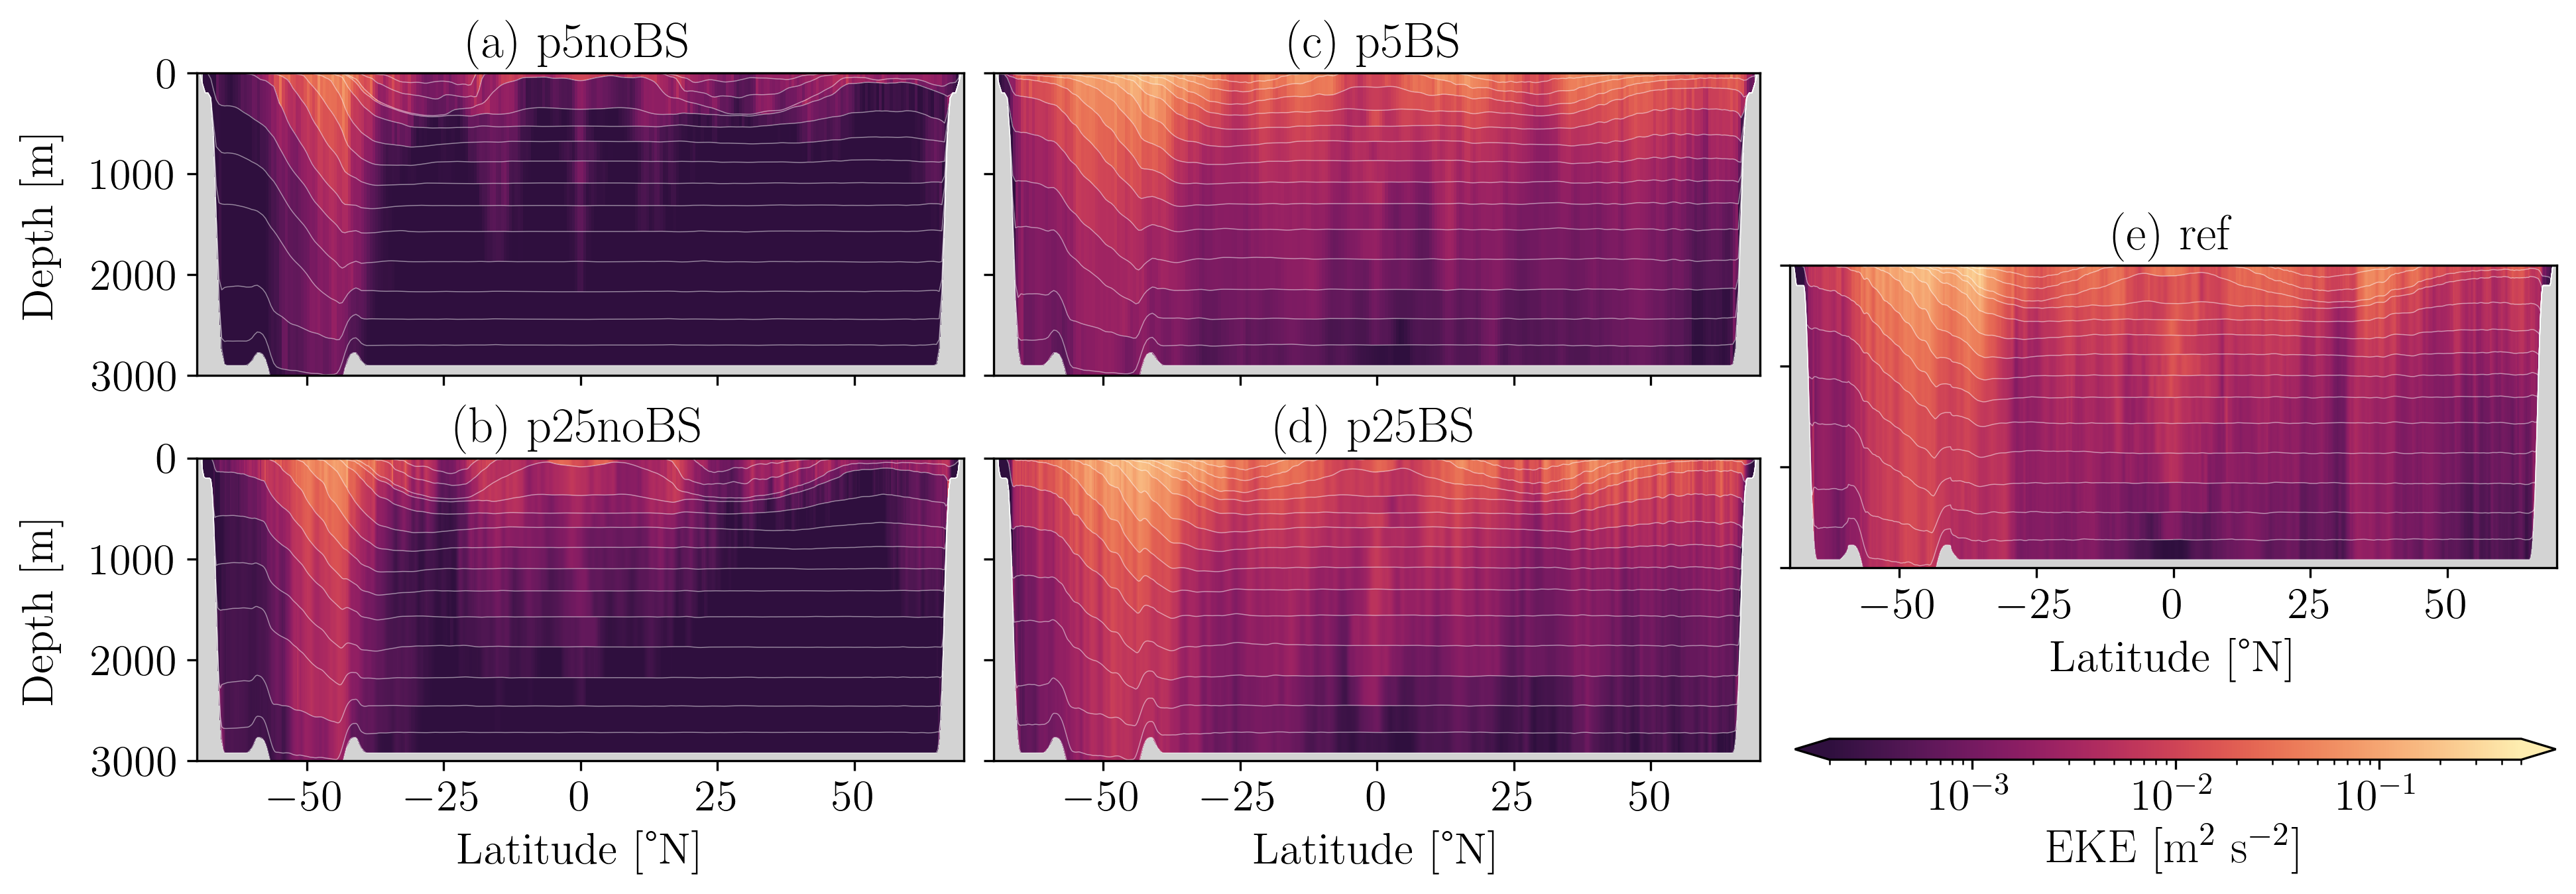

In [16]:
# Create figure
fig = plt.figure(figsize = (16, 7), dpi = 300)
fontsize = 16

vmax = -1
vmin = -3 #-4
ticks = np.linspace(vmin, vmax, 3)

# Layout
gs = gridspec.GridSpec(6, 4, figure = fig, width_ratios = [1, 1, 1, 0.1], height_ratios = [1, 1, 1, 1, 1, 1])

# Subplots
ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[0:2, 1], sharex = ax1, sharey = ax1)
ax3 = fig.add_subplot(gs[2:4, 0], sharex = ax1, sharey = ax1)
ax4 = fig.add_subplot(gs[2:4, 1], sharex = ax1, sharey = ax1)
ax5 = fig.add_subplot(gs[1:3, 2])

# Plot
ax = ax1
plot_zm(p5_noBS_EKE, p5_noBS.h.isel(time = -1), p5_static, ax)
ax.set_xlabel('', fontsize = fontsize)
ax.set_ylabel('Depth [m]', fontsize = fontsize, labelpad = 10)
ax.tick_params(labelsize = fontsize)
ax.set_xticks(np.linspace(-50, 50, 5))

ax = ax2
plot_zm(p5_SQGBS_EKE, p5_SQGBS.h.isel(time = -1), p5_static, ax)
ax.set_xlabel('', fontsize = fontsize)
ax.set_ylabel('', fontsize = fontsize)
ax.tick_params(labelsize = fontsize)
ax.set_xticks(np.linspace(-50, 50, 5))

ax = ax3
plot_zm(p25_noBS_EKE, p25_noBS.h.isel(time = -1), p25_static, ax)
ax.set_xlabel('Latitude [°N]', fontsize = fontsize)
ax.set_ylabel('Depth [m]', fontsize = fontsize, labelpad = 10)
ax.tick_params(labelsize = fontsize)
ax.set_xticks(np.linspace(-50, 50, 5))

ax = ax4
plotted = plot_zm(p25_SQGBS_EKE, p25_SQGBS.h.isel(time = -1), p25_static, ax)
ax.set_xlabel('Latitude [°N]', fontsize = fontsize)
ax.set_ylabel('', fontsize = fontsize)
ax.tick_params(labelsize = fontsize)
ax.set_xticks(np.linspace(-50, 50, 5))

ax = ax5
plotted = plot_zm(p03125_EKE, p03125.h.isel(time = -1), p03125_static, ax)
ax.set_xlabel('Latitude [°N]', fontsize = fontsize)
ax.set_ylabel('', fontsize = fontsize)
ax.tick_params(labelsize = fontsize)
ax.set_xticks(np.linspace(-50, 50, 5))

# Set titles
ax1.set_title('(a) p5noBS', fontsize = fontsize + 2)
ax3.set_title('(b) p25noBS', fontsize = fontsize + 2)
ax2.set_title('(c) p5BS', fontsize = fontsize + 2)
ax4.set_title('(d) p25BS', fontsize = fontsize + 2)
ax5.set_title('(e) ref', fontsize = fontsize + 2)

# Hide labels
ax2.tick_params(labelleft = False)
ax4.tick_params(labelleft = False)
ax5.tick_params(labelleft = False)
ax1.tick_params(labelbottom = False)
ax2.tick_params(labelbottom = False)

# Get bounding boxes of ax4 and ax5 in figure coordinates
pos4 = ax4.get_position()
pos5 = ax5.get_position()

# Create a horizontal colorbar axis:
cbar_ax = fig.add_axes([
    pos5.x0,             # left: align with ax5’s left
    pos4.y0 + 0.013,             # bottom: align with ax4’s bottom
    1.1 * pos5.width,          # width: same as ax5
    0.015                 # height: small (adjust as needed)
])

# Add horizontal colorbar
cbar = fig.colorbar(plotted, cax = cbar_ax, orientation = 'horizontal', extend = 'both')
cbar.set_label(r'EKE [m$^2$ s$^{-2}$]', fontsize = fontsize + 1, labelpad = 2)
cbar.ax.tick_params(labelsize = fontsize)

# Modify spacing between panels
plt.subplots_adjust(wspace = 0.05, hspace = 0.75)

# Save figure
plt.savefig('Fig_zonal_ave_KE.png', bbox_inches = 'tight', dpi = 300)